In [16]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.data import Dataset
# from vae import VAE

In [17]:
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from skimage.transform import resize
import os
from glob import glob
import os.path as path

In [18]:
# reference to Github.com/shaohua0116/VAE_Tensorflow
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

class VAE:
	def __init__(self,learning_rate=1e-4,batch_size=32,no_z=16,mode='fully_connected'):
		self.learning_rate = learning_rate
		self.batch_size = batch_size
		self.no_z = no_z

		tf.reset_default_graph()
		if mode == 'fully_connected':
			self.build_fully_connected()
		elif mode == 'CNN':
			self.build_CNN()

		self.sess = tf.Session()
		self.sess.run(tf.global_variables_initializer())

	def build_fully_connected(self):
		self.x = tf.placeholder(name='input_x',dtype=tf.float32,shape=[None,input_dim])

		# Encode
		# x -> z_mean, z_sigma 
		f1 = fully_connected(self.x,256,scope='enc_fc1',activation_fn=tf.nn.elu)
		f2 = fully_connected(f1,128,scope='enc_fc2',activation_fn=tf.nn.elu)
		f3 = fully_connected(f2,64,scope='enc_fc3',activation_fn=tf.nn.elu)

		self.z_mu = fully_connected(f3,self.no_z,scope='enc_fc4_mu',activation_fn=None)
		self.z_log_sigma_sq = fully_connected(f3,self.no_z,scope='enc_fc4_sigma',activation_fn=None)


		# z_mean, z_sigma, random_normal -> z
		eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),mean=0,stddev=1,dtype=tf.float32)
		self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

		# Decode
		# z -> x_hat
		g1 = fully_connected(self.z,64,scope='gen_fc1',activation_fn=tf.nn.elu)
		g2 = fully_connected(g1,128,scope='gen_fc2',activation_fn=tf.nn.elu)
		g3 = fully_connected(g2,256,scope='gen_fc3',activation_fn=tf.nn.elu)

		self.x_hat = fully_connected(g3,input_dim,scope='gen_out',activation_fn=tf.sigmoid)

		# Loss
		# Loss1: Reconstruction Loss
		# Cross Entropy of original and x_hat
		# proofs
		# https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
		epsilon = 1e-10
		recon_loss = -tf.reduce_sum(self.x*tf.log(epsilon+self.x_hat)+(1-self.x)*tf.log(epsilon+1-self.x_hat),
			axis=1)
		self.recon_loss = tf.reduce_mean(recon_loss)



		# Loss2: Latent loss KL(q(z|x)||p(z))
		# KL divergence 
		# p(z) is a N(0,1)
		latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq),
            axis=1)
		self.latent_loss = tf.reduce_mean(latent_loss)

		self.total_loss = self.recon_loss + self.latent_loss
		self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.total_loss)

		self.losses = {
			'recon_loss': self.recon_loss,
			'latent_loss': self.latent_loss,
			'total_loss': self.total_loss
		}

	# one training pass
	def run_single_step(self,x):
		_,losses = self.sess.run(
			[self.train_op, self.losses],
			feed_dict = {self.x:x})
		return losses

	# x -> x_hat
	def reconstructor(self,x):
		x_hat = self.sess.run(self.x_hat,
			feed_dict = {self.x:x})
		return x_hat

	# z -> x
	def generator(self,z):
		x_hat = self.sess.run(self.x_hat,
			feed_dict = {self.z:z})
		return x_hat

	def transformer(self,x):
		z = self.sess.run(self.z,feed_dict={self.x:x})
		return z







In [19]:
"""Define Dataset and global parameters"""
# data_root=path.expanduser('/home/aitrading/Desktop/GLTransform/output/npyface/')
data_root=path.expanduser('/home/aitrading/Desktop/GLTransform/output/npy128/')
np_files=glob(path.join(data_root,'*.npy'))  # list
mode = 'fully_connected'
# num_sample = 1400
# input_dim = 512*512
num_sample = 2800
input_dim = 128*128

def generate(batch_size):
    n=len(np_files)
    i=0
    while True:
        temp = []
        
        for j in range(batch_size):
            i+=1
            if i>=n:
                return
            temp.append(np.load(np_files[i]).reshape(-1))
        
        yield np.array(temp)
        

In [20]:
# data_set = data_set.batch(32)
def trainer(model_object, learning_rate=1e-4, 
            batch_size=32, num_epoch=31, no_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, no_z=no_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = next(generate(batch_size))
#             batch = data_set.make_one_shot_iterator().get_next()
#             print(batch.shape)
    
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model


# Train a model
# model = trainer(VariantionalAutoencoder)
model = trainer(VAE)

[Epoch 0] recon_loss: 10336.645  latent_loss: 71.884  total_loss: 10408.529  (1.173 sec/epoch)
[Epoch 5] recon_loss: 9480.215  latent_loss: 72.800  total_loss: 9553.015  (1.061 sec/epoch)
[Epoch 10] recon_loss: 9381.678  latent_loss: 51.890  total_loss: 9433.567  (1.081 sec/epoch)
[Epoch 15] recon_loss: 9372.189  latent_loss: 43.098  total_loss: 9415.287  (1.058 sec/epoch)
[Epoch 20] recon_loss: 9375.562  latent_loss: 39.504  total_loss: 9415.066  (1.116 sec/epoch)
[Epoch 25] recon_loss: 9373.582  latent_loss: 37.866  total_loss: 9411.448  (1.058 sec/epoch)
[Epoch 30] recon_loss: 9372.465  latent_loss: 36.756  total_loss: 9409.221  (1.063 sec/epoch)
Done!


In [21]:
def test_reconstruction(model, data_set, h=128, w=128, batch_size=16):
    # Test the trained model: reconstruction
    ds = data_set(batch_size)
    for i in range(8):
        batch = next(ds)
    x_reconstructed = model.reconstructor(batch)

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

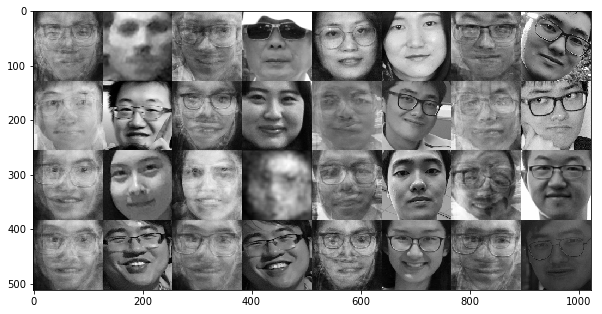

In [22]:
test_reconstruction(model, generate)

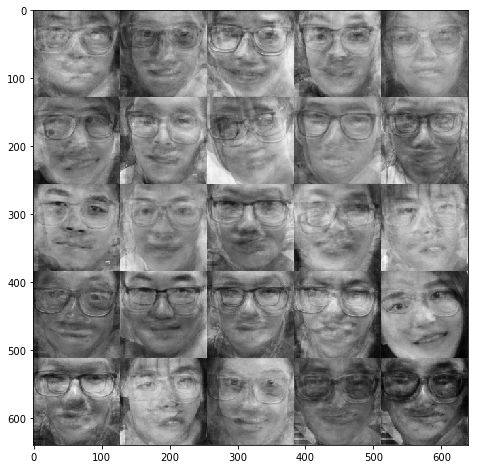

In [23]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
h=128
w=128
z = np.random.normal(size=[model.batch_size, model.no_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

[Epoch 0] recon_loss: 10607.320  latent_loss: 43.508  total_loss: 10650.828  (1.175 sec/epoch)
[Epoch 5] recon_loss: 9984.872  latent_loss: 46.108  total_loss: 10030.979  (1.079 sec/epoch)
[Epoch 10] recon_loss: 9781.605  latent_loss: 39.632  total_loss: 9821.238  (1.091 sec/epoch)
[Epoch 15] recon_loss: 9630.553  latent_loss: 39.265  total_loss: 9669.817  (1.091 sec/epoch)
[Epoch 20] recon_loss: 9492.508  latent_loss: 41.448  total_loss: 9533.955  (1.117 sec/epoch)
[Epoch 25] recon_loss: 9428.292  latent_loss: 37.286  total_loss: 9465.578  (1.107 sec/epoch)
[Epoch 30] recon_loss: 9393.025  latent_loss: 30.936  total_loss: 9423.962  (1.130 sec/epoch)
Done!


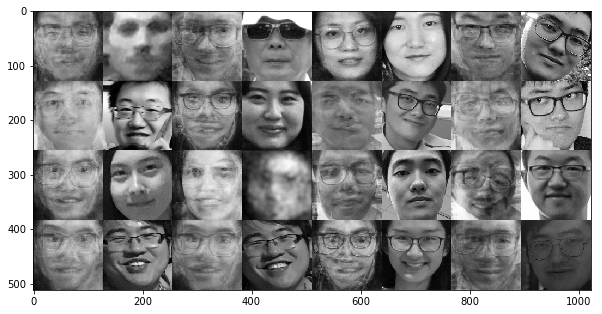

In [25]:
model_2d = trainer(VAE, no_z=2)
test_reconstruction(model, generate)

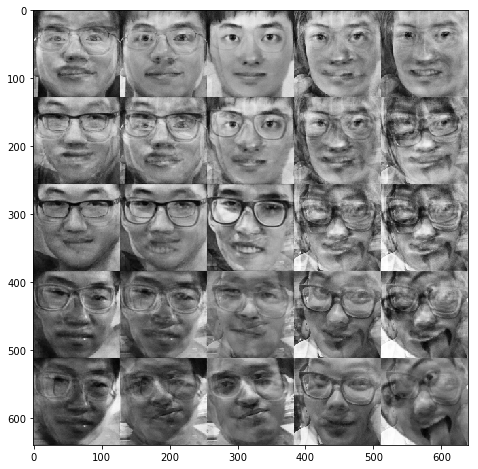

In [26]:
n = 5
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")